# ChatGPT Helped MobileNet transfer learning version

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import os
import cv2
import re
import numpy as np

# Train test split etc

In [2]:
from random import shuffle

In [3]:
#train_images = os.open("./train/")
data = []
for files in os.listdir("./train"):
    #Resize all pictures to the same size
    image = cv2.resize(cv2.imread(os.path.join("./train/", files)),(224,224)) 
    #Split labels on yes or no
    label = re.split(r"\s\(\d+\)",files)[0]
    if label == "yes":
        data.append([np.array(image), np.array([1,0])])
    elif label == "no":
        data.append([np.array(image), np.array([0,1])])  
shuffle(data)         

In [4]:
len(data)

1043

# Assign X and y data, then scale X values

In [6]:
X_data = np.array([i[0] for i in data]).reshape(-1, 224, 224, 3) 
y_data = np.array([i[1] for i in data])#.reshape(-1,1)

X_data = X_data.astype("float32")/255 #This scaling gives us values between 0.0 to 1.0

In [7]:
print("Shape of X: ", X_data.shape)
print("Min val of X: ", X_data.min())
print("Max val of X: ", X_data.max())


Shape of X:  (1043, 224, 224, 3)
Min val of X:  0.0
Max val of X:  1.0


# Load ready model and add data augmentation and dropout

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Add augmentation variable

In [9]:
d_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.15,
    #rescale=1./255
)

In [10]:
# Load MobileNet model pre-trained on ImageNet
base_model = MobileNet(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

In [11]:
# Add new top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation="sigmoid")(x) #try between softmax and sigmoid

In [12]:
# Combine the base model and top layers into a new model
model = keras.Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [14]:

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## Training the model

In [16]:
from sklearn.model_selection import KFold

In [17]:
kf = KFold(n_splits = 3, shuffle=True)#, random_state=42)

In [18]:
fold = 0

for train, test in kf.split(X_data):
    fold += 1
    print("training fold " + str(fold))
    X = X_data[train]
    y = y_data[train]
    x_validation = X_data[test]
    y_validation = y_data[test]

    model_name = "MobileNet-model-aug-fold" + str(fold)
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir="MobileNet-aug/{}".format(model_name))
    pre_tuned_hist = model.fit(X, y, batch_size=32, epochs=5,
                          validation_data=(x_validation, y_validation), callbacks=[tb_callback])
    
model.save("punch-model-MobileNet.h5", overwrite=True, include_optimizer=True)

training fold 1
Epoch 1/5
22/22 [==============================] - 22s 746ms/step - loss: 0.5910 - accuracy: 0.7597 - val_loss: 0.3130 - val_accuracy: 0.8966
Epoch 2/5
22/22 [==============================] - 15s 712ms/step - loss: 0.2302 - accuracy: 0.9266 - val_loss: 0.2229 - val_accuracy: 0.8994
Epoch 3/5
22/22 [==============================] - 15s 685ms/step - loss: 0.1618 - accuracy: 0.9424 - val_loss: 0.1894 - val_accuracy: 0.9195
Epoch 4/5
22/22 [==============================] - 15s 677ms/step - loss: 0.1132 - accuracy: 0.9597 - val_loss: 0.1815 - val_accuracy: 0.9282
Epoch 5/5
22/22 [==============================] - 15s 699ms/step - loss: 0.0948 - accuracy: 0.9712 - val_loss: 0.1805 - val_accuracy: 0.9253
training fold 2
Epoch 1/5
22/22 [==============================] - 21s 910ms/step - loss: 0.1332 - accuracy: 0.9568 - val_loss: 0.0684 - val_accuracy: 0.9856
Epoch 2/5
22/22 [==============================] - 22s 1s/step - loss: 0.0977 - accuracy: 0.9655 - val_loss: 0.1481 

### Loss plot

In [19]:
import matplotlib.pyplot as plt

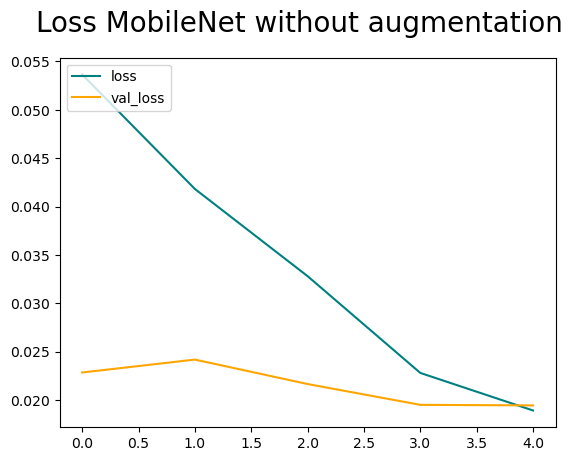

In [20]:
fig = plt.figure()
plt.plot(pre_tuned_hist.history["loss"], color = "teal", label = "loss")
plt.plot(pre_tuned_hist.history["val_loss"], color = "orange", label = "val_loss")
fig.suptitle("Loss MobileNet without augmentation", fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Accuracy plot

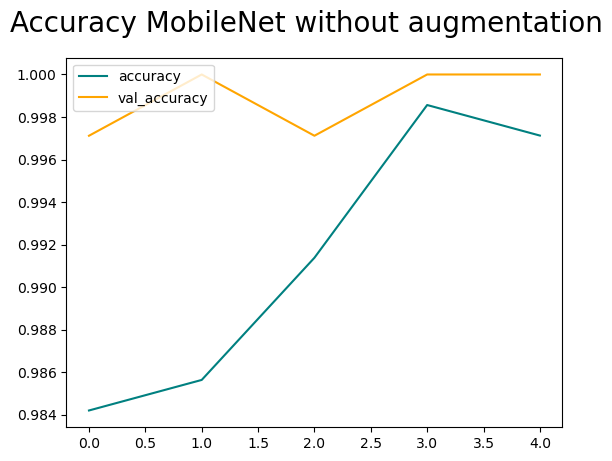

In [21]:
fig = plt.figure()
plt.plot(pre_tuned_hist.history["accuracy"], color = "teal", label = "accuracy")
plt.plot(pre_tuned_hist.history["val_accuracy"], color = "orange", label = "val_accuracy")
fig.suptitle("Accuracy MobileNet without augmentation", fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Test on new image

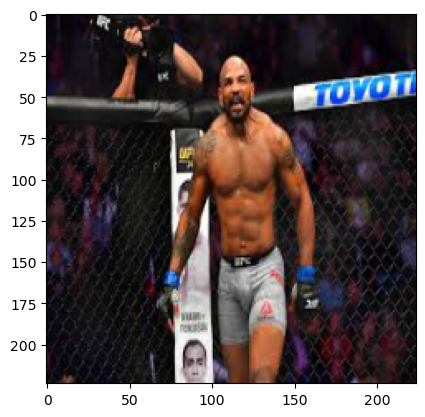

In [22]:
#Image that the model has not seen yet
img_array = cv2.imread("./test/no (4).jpg")
img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
new_array = cv2.resize(img_array, (224,224))
plt.imshow(new_array)
plt.show()

### Make prediction

In [23]:
y_test_pred = model.predict(np.expand_dims(new_array/255, 0))

1/1 [==============================] - 1s 673ms/step


In [24]:
y_test_pred

array([[0.01005609, 0.98776907]], dtype=float32)

# Confusion matrix

In [25]:
#this one was named predictions before, which already existed in the CNN modelling as a variable
predicted = model.predict(x_validation) 
predicted.shape

11/11 [==============================] - 5s 429ms/step


(347, 2)

In [26]:
np.round(predicted)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [27]:
predicted.mean()

0.5008563

In [28]:
# Round the predictions to be able to show them in the confusion matrix
rounded_predictions = np.argmax(predicted, axis=-1)
rounded_predictions

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,

In [29]:
rounded_predictions=(~rounded_predictions.astype(bool)).astype(int)
rounded_predictions

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,

In [30]:
#Extract all elements from index 1 in this array
i = 0
y_val_extract = []

for pair in y_validation:
    y_val_extract.append(y_validation[i][0])
    i+=1
y_val_extract;

In [31]:
from sklearn.metrics import confusion_matrix
import itertools

In [32]:
cm = confusion_matrix(y_true=y_val_extract, y_pred=rounded_predictions)
cm

array([[174,   0],
       [  0, 173]], dtype=int64)

In [33]:
tn, fp, fn, tp = confusion_matrix(y_true=y_val_extract, y_pred=rounded_predictions).ravel()
(tn, fp, fn, tp)

(174, 0, 0, 173)

In [34]:
#Code copied from sklearn
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[174   0]
 [  0 173]]


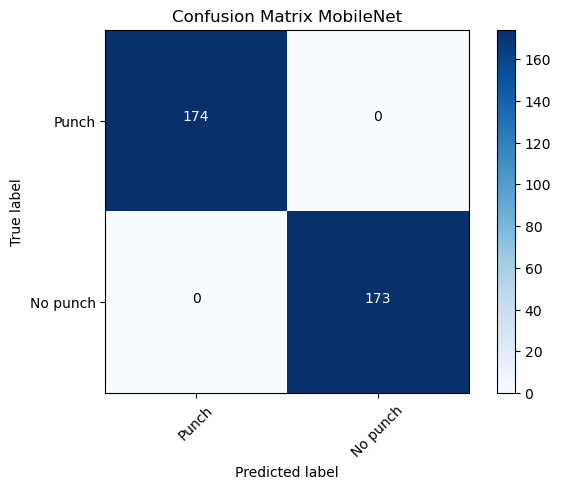

In [35]:
cm_plot_labels = ["Punch", "No punch"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix MobileNet")

# Test predicting

In [36]:
pred_data = []
for files in os.listdir("./test"):
    #Resize all pictures to the same size
    p_image = cv2.resize(cv2.imread(os.path.join("./test/", files)),(224,224)) 
    p_image = cv2.cvtColor(p_image, cv2.COLOR_RGB2BGR)
    #Split labels on yes or no
    label = re.split(r"\s\(\d+\)",files)[0]
    if label == "yes":
        pred_data.append([np.array(p_image), np.array([1,0])])
    elif label == "no":
        pred_data.append([np.array(p_image), np.array([0,1])]) 

In [37]:
np.asanyarray(pred_data).shape

c:\Users\jonat\Anaconda3\envs\mmascore\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(10, 2)

In [38]:
X_pred = np.array([i[0] for i in pred_data]).reshape(-1, 224, 224, 3) 
y_pred = np.array([i[1] for i in pred_data])

X_pred = X_pred.astype("float32")/255

In [39]:
from tensorflow.keras.models import load_model

In [40]:
mob_model = load_model("punch-model-MobileNet.h5")

In [41]:
mob_model.predict(X_pred, verbose=1)

1/1 [==============================] - 1s 710ms/step


array([[9.1279304e-01, 1.1492210e-01],
       [4.3523344e-01, 7.8031904e-01],
       [1.8017514e-01, 8.7239683e-01],
       [1.0056077e-02, 9.8776907e-01],
       [9.8672885e-01, 3.5112876e-02],
       [9.9771619e-01, 4.6376903e-03],
       [9.9993098e-01, 1.2841004e-04],
       [5.7511783e-01, 6.6556978e-01],
       [7.9186666e-01, 2.9857749e-01],
       [9.9705744e-01, 3.0290962e-03]], dtype=float32)

In [42]:
for i in y_pred:
    print(i)

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]


In [43]:
res = mob_model.evaluate(X_pred, y_pred, batch_size=10)
print("test loss, test acc:", res)

1/1 [==============================] - 1s 956ms/step - loss: 0.7850 - accuracy: 0.7000
test loss, test acc: [0.7850466966629028, 0.699999988079071]
